In [1]:
from torch.utils.data import DataLoader, TensorDataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime
from torch import nn, optim
import torchtext.data.utils
import plotly.express as px
import pandas as pd
import torchtext
import torch
import math
import re
import os

seed = 265
torch.manual_seed(seed)

In [2]:

def set_device(device=None):
    """
    Helper function to set device
    """
    if device is None:
        device = (
            torch.device('cuda') if torch.cuda.is_available()
            else torch.device('cpu'))
        print(f"On device {device}.")
    return device

def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader=None, device=None):
    device = set_device()

    n_batch_train = len(train_loader)
    losses_train = []
    losses_val = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for contexts, targets in train_loader:

            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch_train)

        if val_loader is not None:
            loss_val = 0.0
            n_batch_val = len(val_loader)
            model.eval()
            with torch.no_grad():
                for contexts, targets in val_loader:
                    contexts = contexts.to(device=device)
                    targets = targets.to(device=device)
                    outputs = model(contexts)
                    loss_val += loss_fn(outputs, targets).item()
            losses_val.append(loss_val / n_batch_val)
            model.train()

        if epoch == 1 or epoch == n_epochs:
            print('{}  |  Epoch {}  |  Training loss {:.5f} | Validation loss {:.5f}'.format(
                datetime.now().time(), epoch, losses_train[-1], losses_val[-1] if losses_val else 0.0))

    # plot the loss graphs
    plt.plot(losses_train, label='Training loss')
    if losses_val:
        plt.plot(losses_val, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return losses_train, losses_val

def compute_accuracy(model, loader, device=None):
    model.eval()
    device = set_device()

    correct = 0
    total = 0

    with torch.no_grad():
        for contexts, targets in loader:
            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs, dim=1)
            total += len(targets)
            correct += int((predicted == targets).sum())

    acc =  correct / total
    return acc


# 2.1 Word embedding

## Task 2.1.1 and 2.1.2

In [3]:
# tokenizer will split a long text into a list of english words
TOKENIZER_EN = get_tokenizer('basic_english')
# Where we will store / load all our models, datasets, vocabulary, etc.
PATH_GENERATED = './generated/'
# Minimum number of occurence of a word in the text to add it to the vocabulary
MIN_FREQ = 100

def read_files(datapath='./data_train/'):
    """
    Return a list of strings, one for each line in each .txt files in 'datapath'
    """
    # Find all txt files in directory 
    files = os.listdir(datapath)
    files = [datapath + f for f in files if f.endswith(".txt")]
    
    # Stores each line of each book in a list
    lines = []
    for f_name in files:
        with open(f_name, 'r', encoding='utf-8') as f:
            lines += f.readlines()
    return lines

def tokenize(lines, tokenizer=TOKENIZER_EN):
    """
    Tokenize the list of lines
    """
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text

def yield_tokens(lines, tokenizer=TOKENIZER_EN):
    """
    Yield tokens, ignoring names and digits to build vocabulary
    """
    # Match any word containing digit
    no_digits = '\w*[0-9]+\w*'
    # Match word containing a uppercase 
    no_names = '\w*[A-Z]+\w*'
    # Match any sequence containing more than one space
    no_spaces = '\s+'
    
    for line in lines:
        line = re.sub(no_digits, ' ', line)
        line = re.sub(no_names, ' ', line)
        line = re.sub(no_spaces, ' ', line)
        yield tokenizer(line)

def count_freqs(words, vocab):
    """
    Count occurrences of each word in vocabulary in the data
    
    Useful to get some insight on the data and to compute loss weights
    """
    freqs = torch.zeros(len(vocab), dtype=torch.int)
    for w in words:
        freqs[vocab[w]] += 1
    return freqs

def create_vocabulary(lines, min_freq=MIN_FREQ):
    """
    Create a vocabulary (list of known tokens) from a list of strings
    """
    # vocab contains the vocabulary found in the data, associating an index to each word
    vocab = build_vocab_from_iterator(yield_tokens(lines), min_freq=min_freq, specials=["<unk>"])
    # Since we removed all words with an uppercase when building the vocabulary, we skipped the word "I"
    vocab.append_token("i")
    # Value of default index. This index will be returned when OOV (Out Of Vocabulary) token is queried.
    vocab.set_default_index(vocab["<unk>"])
    return vocab

In [4]:
line_books_train = []
line_books_val = []
line_books_test = []

if os.path.isfile(PATH_GENERATED + "words_train.pt"):
    words_train = torch.load(PATH_GENERATED + "words_train.pt")
    words_val = torch.load(PATH_GENERATED + "words_val.pt")
    words_test = torch.load(PATH_GENERATED + "words_test.pt")
else:
    # Get lists of strings, one for each line in each .txt files in 'datapath' 
    lines_books_train = read_files('data_train/')
    lines_books_val = read_files('data_val/')
    lines_books_test = read_files('data_test/')

    # List of words contained in the dataset
    words_train = tokenize(lines_books_train)
    words_val = tokenize(lines_books_val)
    words_test = tokenize(lines_books_test)
    
    torch.save(words_train , PATH_GENERATED + "words_train.pt")
    torch.save(words_val , PATH_GENERATED + "words_val.pt")
    torch.save(words_test , PATH_GENERATED + "words_test.pt")


# ----------------------- Create vocabulary ----------------------------
VOCAB_FNAME = "vocabulary.pt"
# Load vocabulary if you have already generated it
# Otherwise, create it and save it
if os.path.isfile(PATH_GENERATED + VOCAB_FNAME):
    vocab = torch.load(PATH_GENERATED + VOCAB_FNAME)
else:
    # Create vocabulary based on the words in the training dataset
    vocab = create_vocabulary(lines_books_train, min_freq=MIN_FREQ)
    torch.save(vocab, PATH_GENERATED + VOCAB_FNAME)
    

# ------------------------ Quick analysis ------------------------------
VOCAB_SIZE = len(vocab)
print("Total number of words in the training dataset:     ", len(words_train))
print("Total number of words in the validation dataset:   ", len(words_val))
print("Total number of words in the test dataset:         ", len(words_test))
print("Number of distinct words in the training dataset:  ", len(set(words_train)))
print("Number of distinct words kept (vocabulary size):   ", VOCAB_SIZE)


# # GJØR DEN RASKERE 
# freqs = count_freqs(words_train, vocab)
# print("occurences:\n", [(f.item(), w) for (f, w)  in zip(freqs, vocab.lookup_tokens(range(VOCAB_SIZE)))])

Total number of words in the training dataset:      2684706
Total number of words in the validation dataset:    49526
Total number of words in the test dataset:          124152
Number of distinct words in the training dataset:   52105
Number of distinct words kept (vocabulary size):    1880


In [5]:
sets_1 = ['num_word_train', 'num_word_val', 'num_word_test']
size_1 = [len(words_train), len(words_val), len(words_test)]

df_1 = pd.DataFrame(list(zip(sets_1, size_1)),
               columns =['Sets', 'size'])

fig = px.bar(df_1, x="Sets", y="size", title="Distribution of words in train, val, test sets")
fig.show()

sets_2 = ['dist_word_train', 'vocab_size']
size_2 = [ len(set(words_train)),  VOCAB_SIZE]

sets_1 = ['num_word_train', 'num_word_val', 'num_word_test']
size_1 = [len(words_train), len(words_val), len(words_test)]

df_2 = pd.DataFrame(list(zip(sets_2, size_2)),
               columns =['Sets', 'size'])

fig = px.bar(df_2, x="Sets", y="size", title="Distinct words in train and vocab")
fig.show()

sets_2 = ['dist_word_train', 'vocab_size']
size_2 = [ len(set(words_train)),  VOCAB_SIZE]

In [6]:
# ------------------------ Define targets ------------------------------
def compute_label(w):
    """
    helper function to define MAP_TARGET
    
    - 0 = 'unknown word'
    - 1 = 'punctuation' (i.e. the '<unk>' token)
    - 2 = 'is an actual word'
    """
    if w in ['<unk>']:
        return 0
    elif w in [',', '.', '(', ')', '?', '!']:
        return 1
    else:
        return 2

# true labels for this task:
MAP_TARGET = {
    vocab[w]:compute_label(w) for w in vocab.lookup_tokens(range(VOCAB_SIZE))
}

# context size for this task 
CONTEXT_SIZE = 3


# ---------------- Define context / target pairs -----------------------
def create_dataset(
    text, vocab, 
    context_size=CONTEXT_SIZE, map_target=None
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """
    
    n_text = len(text)
    n_vocab = len(vocab)
    
    # Change labels if only a few target are kept, otherwise, each word is
    # associated with its index in the vocabulary
    if map_target is None:
        map_target = {i:i for i in range(n_vocab)}
    
    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []
    for i in range(n_text - 2*context_size):
        
        # Word used to define target
        t = txt[i + context_size]
        
        # Context before the target and after the target. 
        c = txt[i: i+context_size]
        c += txt[i+context_size+1 : i + (2*context_size)+1]
        
        if compute_label(vocab.lookup_token(t)) == 2:
            targets.append(map_target[t])
            contexts.append(torch.tensor(c))
            
    # contexts of shape (N_dataset, context_size)
    # targets of shape  (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs
    return TensorDataset(contexts, targets)

def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

data_train_embedding = load_dataset(words_train, vocab, "data_train_embedding.pt")
data_val_embedding = load_dataset(words_val, vocab, "data_val_embedding.pt")
data_test_embedding = load_dataset(words_test, vocab, "data_test_embedding.pt")

## Task 2.1.3

In [7]:

class MyEmbedding1(nn.Module):
    
    def __init__(self, embedding_dim, context_size=CONTEXT_SIZE):
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)

        # Regular MLP         
        self.fc1 = nn.Linear(embedding_dim*context_size*2, 256)
        self.fc2 = nn.Linear(256, VOCAB_SIZE)

    def forward(self, x):

        out = self.embedding(x)
        
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = self.fc2(out)
        return out
    
    
class MyEmbedding2(nn.Module):
    
    def __init__(self, embedding_dim, context_size=CONTEXT_SIZE):
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)

        # Regular MLP         
        self.fc1 = nn.Linear(embedding_dim*context_size*2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, VOCAB_SIZE)

    def forward(self, x):

        out = self.embedding(x)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

class MyEmbedding3(nn.Module):
    
    def __init__(self, embedding_dim, context_size=CONTEXT_SIZE):
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)

        # Regular MLP         
        self.fc1 = nn.Linear(embedding_dim*context_size*2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, VOCAB_SIZE)

    def forward(self, x):

        out = self.embedding(x)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out



## Task 2.1.4

On device cpu.
On device cpu.
15:01:23.444378  |  Epoch 1  |  Training loss 4.38984 | Validation loss 3.85965
15:11:58.954095  |  Epoch 10  |  Training loss 3.28014 | Validation loss 3.38346


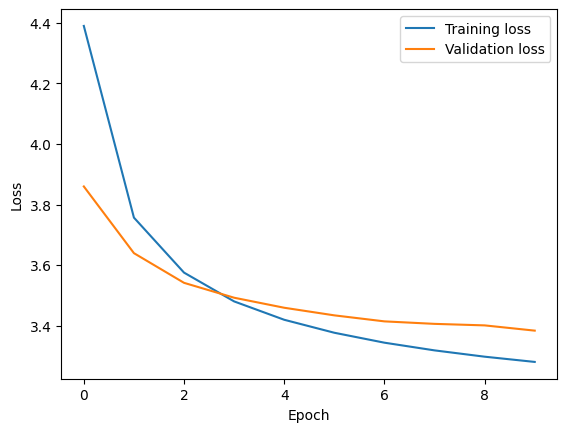

On device cpu.
On device cpu.
Training Accuracy:     0.3241
Validation Accuracy:   0.3077
On device cpu.
15:13:56.481626  |  Epoch 1  |  Training loss 4.29571 | Validation loss 3.75986
15:27:56.416564  |  Epoch 10  |  Training loss 3.14141 | Validation loss 3.29719


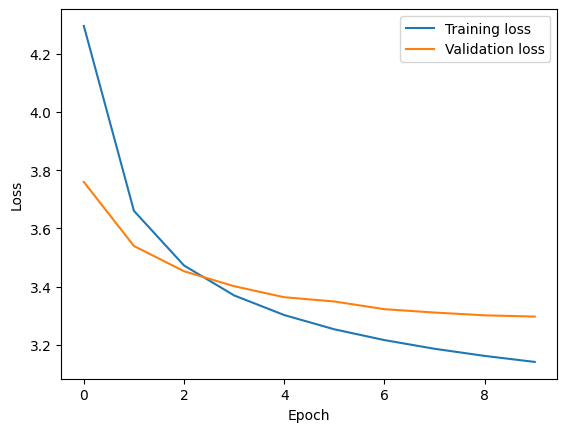

On device cpu.
On device cpu.
Training Accuracy:     0.3462
Validation Accuracy:   0.3217
On device cpu.
15:29:53.362864  |  Epoch 1  |  Training loss 4.37895 | Validation loss 3.83170
15:43:09.885793  |  Epoch 10  |  Training loss 3.25063 | Validation loss 3.32883


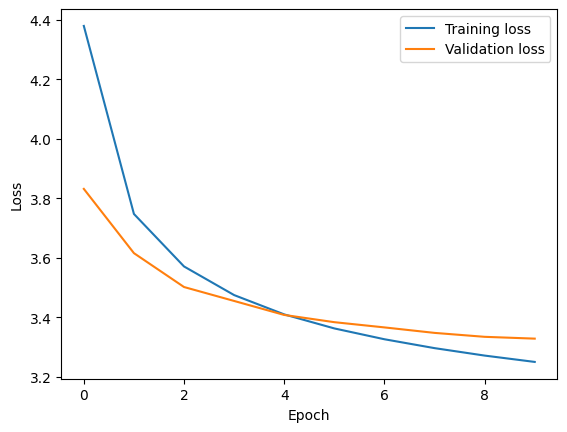

On device cpu.
On device cpu.
Training Accuracy:     0.3346
Validation Accuracy:   0.3117
On device cpu.
Best embedding model has test accuracy 0.3048


In [8]:
torch.manual_seed(seed)
device = set_device()

batch_size=512
train_loader_embedding = DataLoader(data_train_embedding, batch_size=batch_size, shuffle=True)
val_loader_embedding = DataLoader(data_val_embedding, batch_size=batch_size, shuffle=True)
test_loader_embedding = DataLoader(data_test_embedding, batch_size=batch_size, shuffle=True)

emb_dim = 10

embedding_model_1 = MyEmbedding1(emb_dim)
embedding_model_2 = MyEmbedding2(emb_dim)
embedding_model_3 = MyEmbedding3(emb_dim)

embedding_models = [embedding_model_1,embedding_model_2, embedding_model_3]

best_embedding_model = None
best_embedding_acc = 0 
best_emb_train_losses, best_emb_val_losses = None, None

if os.path.isfile(PATH_GENERATED + 'best_embedding_model.pt'):
    # Load the trained models
    best_embedding_model = torch.load(PATH_GENERATED + 'best_embedding_model.pt', map_location=torch.device('cpu'))
    best_embedding_model.to(device)
else:
    num_trained = 0
    for model in embedding_models:
        num_trained +=1 

        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()                             
        n_epochs=10

        train_losses, val_losses = train(n_epochs, optimizer, model, loss_fn, train_loader_embedding, val_loader_embedding)

        acc_train = compute_accuracy(model, train_loader_embedding)
        acc_val = compute_accuracy(model, val_loader_embedding)

        if best_embedding_acc < acc_val: 
            best_embedding_model = model 
            best_embedding_acc = acc_train
            best_emb_train_losses, best_emb_val_losses
        
        print("Training Accuracy:     %.4f" %acc_train)
        print("Validation Accuracy:   %.4f" %acc_val)

    torch.save(best_embedding_model.to(device=device), PATH_GENERATED + 'best_embedding_model.pt')


accuracy_embedding = compute_accuracy(best_embedding_model, test_loader_embedding)
print('Best embedding model has test accuracy %.4f' %accuracy_embedding)

## Task 2.1.5

In [9]:

def cos_sin(weights): 
    similarity_matrix = []
    for i in range(len(weights)):
        similarity_matrix.append(F.cosine_similarity(weights[i], weights, dim=1))
    return similarity_matrix



# Load trained embedding model and vocabulary
model_path = 'generated/best_embedding_model.pt'
vocab_path = "generated/vocabulary.pt"
model = torch.load(model_path, map_location=torch.device('cpu'))
vocab = torch.load(vocab_path, map_location=torch.device('cpu'))


# Compute cosine similarity matrix
weights = model.embedding.weight
similarity_matrix = cos_sin(weights)

sample_words = ['head', 'four', 'boy', 'no', 'he', 'the', 'other', 'coffin']

top_k = 10

for word in sample_words:

    if word in vocab:

        idx = vocab[word]
        sim_scores = similarity_matrix[idx]
        sim_vals, sim_indices = torch.topk(sim_scores, 10)
        #sim_indices = np.argsort(sim_scores)[:top_k]

        sim_words = [vocab.lookup_token(i) for i in sim_indices]
        print("Most similar words to '%s':" % word)
        print(sim_words)


Most similar words to 'head':
['head', 'finger', 'eyes', 'lips', 'face', 'mouth', 'chest', 'arm', 'fingers', 'throat']
Most similar words to 'four':
['four', 'three', 'two', 'seven', 'six', 'eight', 'twelve', 'five', 'fifteen', 'several']
Most similar words to 'boy':
['boy', 'dog', 'child', 'maid', 'cat', 'lad', 'servant', 'devil', 'doctor', 'master']
Most similar words to 'no':
['no', 'any', 'been', 'become', 'different', 'such', 'similar', 'five', 'ten', 'forty']
Most similar words to 'he':
['he', 'she', 'nobody', 'they', 'everyone', 'i', 'everybody', 'immediately', 'someone', 'therefore']
Most similar words to 'the':
['the', 'our', 'its', 'their', 'these', 'thy', 'la', 'my', 'each', 'his']
Most similar words to 'other':
['other', 'material', 'higher', 'bulbs', 'further', 'nine', 'persons', 'main', 'elder', 'chiefs']
Most similar words to 'coffin':
['coffin', 'conversation', 'intelligence', 'land', 'bed', 'district', 'mist', 'house', 'service', 'gloom']


## Task 2.1.6

In [10]:
# vocab_df = pd.DataFrame(vocab.lookup_tokens([i for i in range(len(vocab))]))
# vocab_df.to_csv('vocab_df.tsv', sep="\t", header=False, index=False)

# embedding_df = pd.DataFrame(model.embedding.weight.data.numpy())
# embedding_df.to_csv('embedding_df.tsv', sep="\t", header=False, index=False)

# Task 2.2.1

In [11]:

words = ['be', 'am', 'are', 'is', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'having']
count = [words_train.count(w) for w in words]

df = pd.DataFrame(list(zip(words, count)),
               columns =['Words', 'count'])

fig = px.bar(df, x="Words", y="count", title="Distribution of words in training data")
fig.show()


In [20]:
# ------------------------ Define targets ------------------------------
def compute_label_conjugation(w):
    """
    helper function to define MAP_TARGET
    
    - 0 = 'unknown word'
    - 1 = 'punctuation' (i.e. the '<unk>' token)
    - 2 = 'is an actual word'
    """
    if w in ['be', 'am', 'are', 'is', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'having']:
        return 0
    else:
        return 1

# true labels for this task:
MAP_TARGET = {}
i = 0
for word in ['be', 'am', 'are', 'is', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'having']: 
    MAP_TARGET[word] = i
    i += 1

# context size for this task 
CONTEXT_SIZE = 3


# ---------------- Define context / target pairs -----------------------
def create_dataset_conjugation(
    text, vocab, 
    context_size=CONTEXT_SIZE, map_target=MAP_TARGET
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """
    
    n_text = len(text)
    n_vocab = len(vocab)
    
    # Change labels if only a few target are kept, otherwise, each word is
    # associated with its index in the vocabulary
    if map_target is None:
        map_target = {i:i for i in range(n_vocab)}
    
    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []
    for i in range(n_text - 2*context_size):
        
        # Word used to define target
        t = txt[i + context_size]
        
        # Context before the target and after the target. 
        c = txt[i: i+context_size]
        c += txt[i+context_size+1 : i + (2*context_size)+1]
        
        if compute_label_conjugation(vocab.lookup_token(t)) == 0:
            targets.append(map_target[vocab.lookup_token(t)])
            contexts.append(torch.tensor(c))
            
    # contexts of shape (N_dataset, context_size)
    # targets of shape  (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs

    print(len(contexts), len(targets))
    return TensorDataset(contexts, targets)

def load_dataset_conjugation(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_dataset_conjugation(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

data_train_conjugation = load_dataset_conjugation(words_train, vocab, "data_train_conjugation.pt")
data_val_conjugation = load_dataset_conjugation(words_val, vocab, "data_val_conjugation.pt")
data_test_conjugation = load_dataset_conjugation(words_test, vocab, "data_test_conjugation.pt")

print(len(data_test_conjugation))

4765


In [13]:
#MLP 

class MLP(nn.Module):
    def __init__(self, embedding_matrix, max_len):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.fc1 = nn.Linear(max_len * embedding_matrix.shape[1], 256)                                       
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 12)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        x = embeddings.view(embeddings.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

#MLP with Attention

class SimpleHeadDotProductSelfAttention(nn.Module):
    def __init__(self, emb_dim, p):
        super(SimpleHeadDotProductSelfAttention, self).__init__()
        self.W_q = nn.Linear(emb_dim, p)        #Learnable parameters
        self.W_k = nn.Linear(emb_dim, p)        #Learnable parameters
        self.W_v = nn.Linear(emb_dim, p)        #Learnable parameters
        self.sqrt_p = math.sqrt(p)              
        
    def forward(self, x):
        Q = self.W_q(x)                         
        K = self.W_k(x)
        V = self.W_v(x)
        
        #Calculating f an using BMM as described: 
        soft_max = torch.softmax(torch.bmm(Q, (K.transpose(1, 2))) / self.sqrt_p, dim=-1)
        h = torch.bmm(soft_max, V)
        return h

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, p, n_head, max_len):
        super(MultiHeadAttention, self).__init__()
        self.p = p
        self.n_head = n_head
        self.max_len = max_len
        self.heads = nn.ModuleList([SimpleHeadDotProductSelfAttention(emb_dim, p) for _ in range(n_head)])
        self.W_o = nn.Linear(p * n_head, emb_dim)

    def forward(self, x):
        head_outputs = torch.zeros(self.n_head, x.shape[0], self.max_len, self.p)
        for i, head in enumerate(self.heads): 
            head_outputs[i] = head(x)
        h = head_outputs.permute(1, 2, 3, 0)                                        #Changing placement to [batch_size, max_len, p and n_head]
        h = torch.reshape(h, (x.shape[0], self.max_len, self.p*self.n_head))        #Reshaping to [batc_size, max_len, p*n_head]
        h = self.W_o(h)
        return h

class MLPWithAttention(nn.Module):   
    def __init__(self, embedding_matrix, emb_dim, max_len, num_heads, p):
        super(MLPWithAttention, self).__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix)
        self.positional_encoding_layer = self.positional_encoding(max_len, emb_dim)
        self.multihead_attention_layer = MultiHeadAttention(emb_dim, p, num_heads, max_len)
        
        
        # Define the MLP layers
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(emb_dim*max_len, 256)
        self.fc2 = nn.Linear(256, 12)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.positional_encoding_layer + x
        x = self.multihead_attention_layer(x)   

        x = self.fc1(torch.flatten(x, 1))  
        x = self.relu(x)
        x = self.fc2(x)

        return x

    
    def positional_encoding(self, max_len, emb_dim):
        pe = torch.zeros(max_len, emb_dim)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        pe = pe.to(device)
        for i in range(max_len):
            for j in range(0, emb_dim, 2):
                k = j // 2
                pe[i, j] = math.sin(i / (10000 ** (k / emb_dim)))
                pe[i, j + 1] = math.cos(i / (10000 ** (k / emb_dim)))
        return pe

# RNN 
   
class RNN_conjugation(nn.Module):
    def __init__(self, embedding_matrix, hidden_size):
        super(RNN_conjugation, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.rnn = nn.LSTM(embedding_matrix.shape[1], hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 12)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, c_n) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out

On device cpu.
On device cpu.
15:43:40.651671  |  Epoch 1  |  Training loss 1.47170 | Validation loss 1.22311
15:43:51.546827  |  Epoch 10  |  Training loss 0.99224 | Validation loss 0.98232


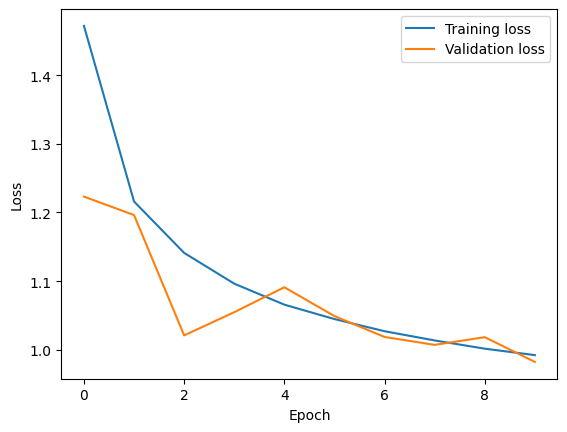

On device cpu.
On device cpu.
Training Accuracy:     0.6323
Validation Accuracy:   0.5950
On device cpu.
15:43:55.232971  |  Epoch 1  |  Training loss 1.62124 | Validation loss 1.31069
15:44:18.513290  |  Epoch 10  |  Training loss 1.09268 | Validation loss 1.05974


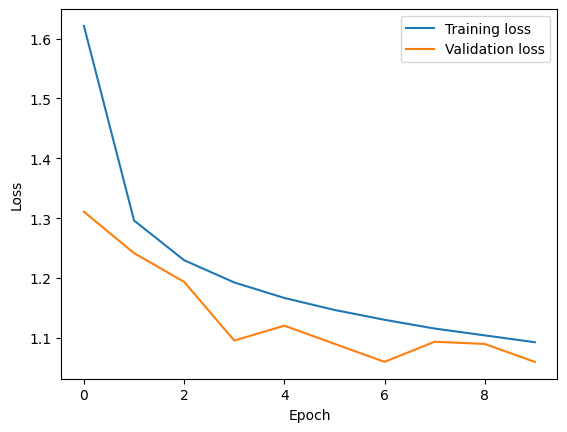

On device cpu.
On device cpu.
Training Accuracy:     0.5924
Validation Accuracy:   0.5710
On device cpu.
15:44:21.599450  |  Epoch 1  |  Training loss 2.21365 | Validation loss 2.00790
15:44:34.252388  |  Epoch 10  |  Training loss 1.31063 | Validation loss 1.28450


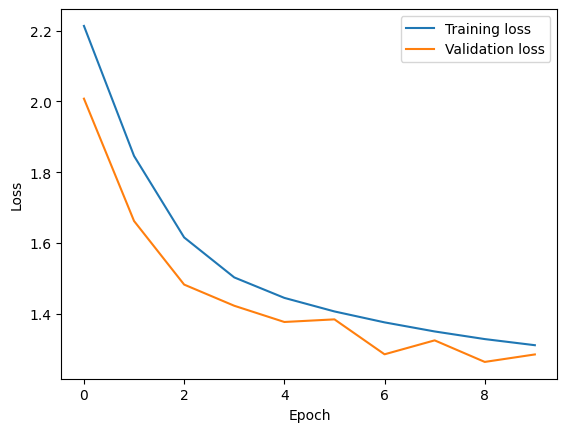

On device cpu.
On device cpu.
Training Accuracy:     0.5245
Validation Accuracy:   0.5293
On device cpu.
Best conjugation model has test accuracy 0.5343


In [14]:

torch.manual_seed(seed)
device = set_device()

batch_size=512
train_loader_conjugation = DataLoader(data_train_conjugation, batch_size=batch_size, shuffle=True)
val_loader_conjugation = DataLoader(data_val_conjugation, batch_size=batch_size, shuffle=True)
test_loader_conjugation = DataLoader(data_test_conjugation, batch_size=batch_size, shuffle=True)

conjugation_model_1 = MLP(best_embedding_model.embedding.weight.data, 2*CONTEXT_SIZE)
conjugation_model_2 = MLPWithAttention(best_embedding_model.embedding.weight.data, emb_dim, 2*CONTEXT_SIZE, 3, 7)
conjugation_model_3 = RNN_conjugation(best_embedding_model.embedding.weight.data, 10, 4)

conjugation_models = [conjugation_model_1, conjugation_model_2, conjugation_model_3]

best_conjugation_model = None
best_conjugation_acc = 0
best_con_train_losses, best_con_val_losses = None, None 

if os.path.isfile(PATH_GENERATED + 'best_conjugation_model.pt'):
    # Load the trained models
    best_conjugation_model = torch.load(PATH_GENERATED + 'best_conjugation_model.pt', map_location=torch.device('cpu'))
    best_conjugation_model.to(device)
else:

    num_trained = 0
    for model in conjugation_models:
        num_trained +=1 

        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()                             
        n_epochs=10

        train_losses, val_losses = train(n_epochs, optimizer, model, loss_fn, train_loader_conjugation,val_loader_conjugation)

        acc_train = compute_accuracy(model, train_loader_conjugation)
        acc_val = compute_accuracy(model, val_loader_conjugation)

        if best_conjugation_acc < acc_val: 
            best_conjugation_model = model 
            best_conjugation_acc = acc_val
            best_con_train_losses, best_con_val_losses = train_losses, val_losses
        
        print("Training Accuracy:     %.4f" %acc_train)
        print("Validation Accuracy:   %.4f" %acc_val)

    torch.save(best_conjugation_model.to(device=device), PATH_GENERATED + 'best_conjugation_model.pt')

accuracy_conjugation = compute_accuracy(best_conjugation_model, test_loader_conjugation)
print('Best conjugation model has test accuracy %.4f' %accuracy_conjugation)

# Task 2.3

In [15]:

# true labels for this task:
MAP_TARGET = {
    vocab[w]:compute_label(w) for w in vocab.lookup_tokens(range(VOCAB_SIZE))
}

# context size for this task 
CONTEXT_SIZE = 3


# ---------------- Define context / target pairs -----------------------
def create_dataset_generation(
    text, vocab, 
    context_size=CONTEXT_SIZE, map_target=None
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """
    
    n_text = len(text)
    n_vocab = len(vocab)
    
    # Change labels if only a few target are kept, otherwise, each word is
    # associated with its index in the vocabulary
    if map_target is None:
        map_target = {i:i for i in range(n_vocab)}
    
    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []
    for i in range(n_text - context_size):
        
        # Word used to define target
        t = txt[i + context_size]
        
        # Context before the target. 
        c = txt[i: i+context_size]
        
        if compute_label(vocab.lookup_token(t)) == 2:
            targets.append(map_target[t])
            contexts.append(torch.tensor(c))
            
    # contexts of shape (N_dataset, context_size)
    # targets of shape  (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs
    return TensorDataset(contexts, targets)

def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_dataset_generation(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

data_train_generation = load_dataset(words_train, vocab, "data_train_generation.pt")
data_val_generation  = load_dataset(words_val, vocab, "data_val_generation.pt")
data_test_generation  = load_dataset(words_test, vocab, "data_tes_generationt.pt")

In [16]:
class RNN_generation(nn.Module):
    def __init__(self, embedding_matrix, hidden_size):
        super(RNN_generation, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.rnn = nn.LSTM(embedding_matrix.shape[1], hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, VOCAB_SIZE)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, c_n) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out

On device cpu.
On device cpu.
15:45:16.198043  |  Epoch 1  |  Training loss 5.72258 | Validation loss 5.39875
15:51:18.085000  |  Epoch 10  |  Training loss 5.03369 | Validation loss 4.94207


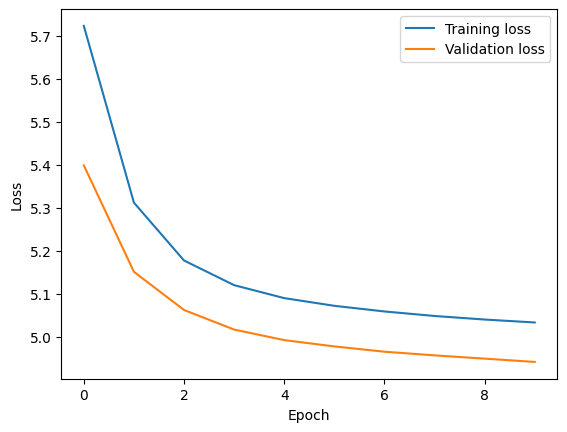

On device cpu.
On device cpu.
Training Accuracy:     0.1384
Validation Accuracy:   0.1354
On device cpu.
15:52:16.879930  |  Epoch 1  |  Training loss 5.63586 | Validation loss 5.28589
15:58:40.040382  |  Epoch 10  |  Training loss 4.89499 | Validation loss 4.80454


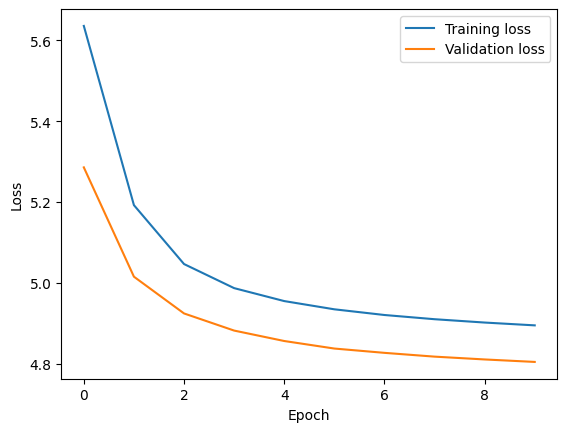

On device cpu.
On device cpu.
Training Accuracy:     0.1436
Validation Accuracy:   0.1392
On device cpu.
15:59:39.631135  |  Epoch 1  |  Training loss 5.53415 | Validation loss 5.14572
16:05:52.495657  |  Epoch 10  |  Training loss 4.82681 | Validation loss 4.73407


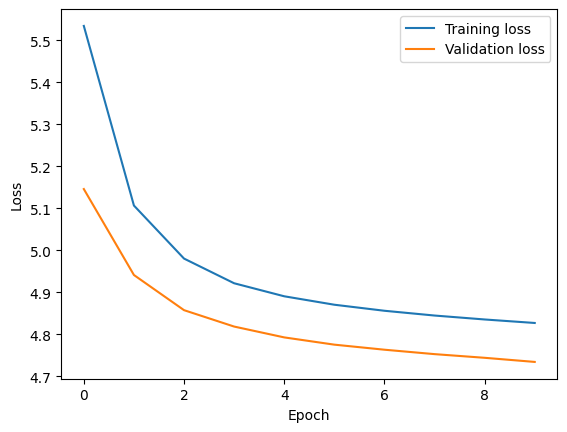

On device cpu.
On device cpu.
Training Accuracy:     0.1526
Validation Accuracy:   0.1489
On device cpu.
Best text generation model has test accuracy 0.1740


In [17]:

torch.manual_seed(seed)
device = set_device()

batch_size=512
train_loader_generation = DataLoader(data_train_generation, batch_size=batch_size, shuffle=True)
val_loader_generation = DataLoader(data_val_generation, batch_size=batch_size, shuffle=True)
test_loader_generation = DataLoader(data_test_generation, batch_size=batch_size, shuffle=True)

generation_model_1 = rnn_generation = RNN_generation(best_embedding_model.embedding.weight.data, 4)
generation_model_2 = rnn_generation = RNN_generation(best_embedding_model.embedding.weight.data, 6)
generation_model_3 = rnn_generation = RNN_generation(best_embedding_model.embedding.weight.data, 8)

generation_models = [generation_model_1,generation_model_2, generation_model_3]

best_generation_model = None
best_generation_acc = 0 
best_gen_train_losses, best_gen_val_losses = None, None

if os.path.isfile(PATH_GENERATED + 'best_generation_model.pt'):
    # Load the trained models
    best_generation_model = torch.load(PATH_GENERATED + 'best_generation_model.pt', map_location=torch.device('cpu'))
    best_generation_model.to(device)
else:
    num_trained = 0
    for model in generation_models:
        num_trained +=1 

        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()                             
        n_epochs=10

        train_losses, val_losses = train(n_epochs, optimizer, model, loss_fn, train_loader_generation, val_loader_generation)

        acc_train = compute_accuracy(model, train_loader_generation)
        acc_val = compute_accuracy(model, val_loader_generation)

        if best_generation_acc < acc_val: 
            best_generation_model = model 
            best_generation_acc = acc_val
            best_gen_train_losses, best_gen_val_losses = train_losses, val_losses
        
        print("Training Accuracy:     %.4f" %acc_train)
        print("Validation Accuracy:   %.4f" %acc_val)

    torch.save(best_generation_model.to(device=device), PATH_GENERATED + 'best_generation_model.pt')

accuracy_generation = compute_accuracy(best_generation_model, test_loader_generation)
print('Best text generation model has test accuracy %.4f' %accuracy_generation)

In [19]:

tokenizer = TOKENIZER_EN

def beam_search(model, input_text, beam_size, max_length):

    input_ids = tokenizer(input_text)
    input_ids = torch.tensor([vocab[token] for token in input_ids], dtype=torch.long).unsqueeze(0)

    beam = [(input_ids, 0)]

    log_softmax = nn.LogSoftmax(dim=1)
    
    for i in range(max_length):
        new_beam = []

        for seq, score in beam:

            output = model(seq.to(device))
            scores = log_softmax(output).squeeze(0)
            top_k_scores, top_k_tokens = torch.topk(scores, beam_size)

            for j in range(beam_size):
                token = top_k_tokens[j].item()
                new_score = top_k_scores[j].item() + score
                new_seq = torch.cat([seq, torch.tensor([[token]], dtype=torch.long)], dim=1) 
                new_beam.append((new_seq, new_score))
        
        beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_size]
        
    best_seq = beam[0][0]

    output_tokens = [vocab.lookup_token(token) for token in best_seq.squeeze(0).tolist()]
    return output_tokens



if not os.path.isfile(PATH_GENERATED + "best_generation_model.pt"):
    print("You need to run the ipynb-file.")
else:

    model = torch.load(PATH_GENERATED + "best_generation_model.pt", map_location=torch.device('cpu'))


    input_text = 'the girl is'
    beam_size = 3
    max_length = 4
    result = beam_search(model, input_text, beam_size, max_length)

    print(result)

['the', 'girl', 'is', 'not', 'not', 'to', 'be']
